In [40]:
import pandas as pd
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from metrics import metrics
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


In [41]:
RS = 42

In [42]:
data = pd.read_csv("../data/whole_data.csv").iloc[:, 4:].drop("type", axis=1).dropna()

features, labels = data.drop("present", axis=1), data["present"]

scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(features))

corr = features.corr()

candidates = []  # видно, что связаны одни и те же, поэтому одномерного списка достаточно
treshold = 0.8
for row in corr.iterrows():
  for col in row[1].items():
    if row[0] != col[0] and col[1] > treshold and col[0] not in candidates:
      candidates.append(col[0])

candidates



[3, 5, 7, 10, 1]

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, random_state=RS, train_size=0.8)

cnt_1 = Y_train[Y_train == 1].size
cnt_0 = Y_train[Y_train == 0].size
weight_for_1 = cnt_0 / cnt_1

class_weight = {0: 1, 1: 4}

### 1. Коррелирующие параметры

<Axes: >

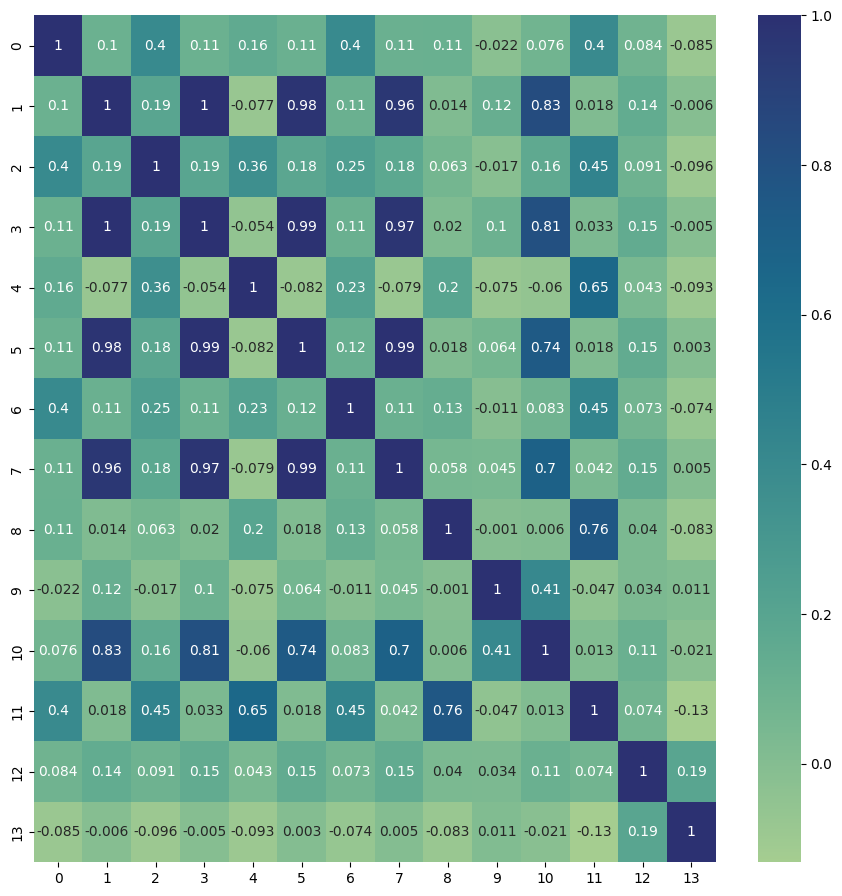

In [44]:
plt.figure(figsize=(11, 11))

corr = features.corr()
sns.heatmap(corr.round(3), cmap="crest", annot=True)

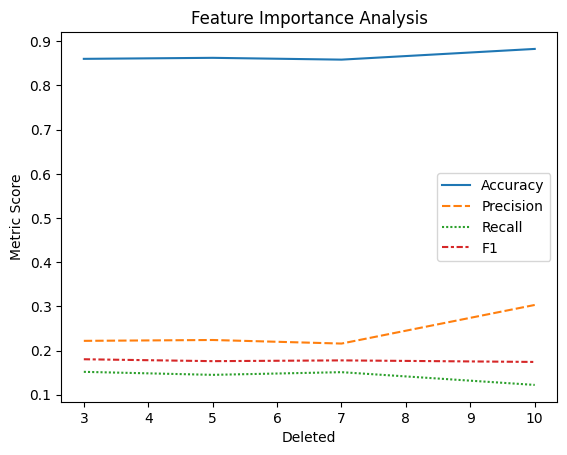

In [45]:
# Make a copy of features
features_copy = features.copy()
draw_data = []

# Scale the data once (more efficient than scaling in each iteration)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_copy)

for c in candidates[:-1]:
    # Drop the feature and scale remaining features
    temp_features = features_scaled[:, features_copy.columns != c]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        temp_features, labels, random_state=RS, train_size=0.8
    )
    
    # Use better solver and more iterations
    clf = LogisticRegression(
        max_iter=1000,  # Increased from 100
        class_weight=class_weight,
        solver='lbfgs',  # Good default solver
        penalty='l2',    # Standard regularization
        tol=1e-4         # Tolerance for stopping
    )
    
    clf.fit(X_train, y_train)
    metrics_dict = metrics(clf.predict(X_test), y_test, output=False)
    metrics_dict["Deleted"] = c
    draw_data.append(metrics_dict)

# Create and plot results
draw_df = pd.DataFrame(draw_data).set_index("Deleted")
sns.lineplot(draw_df)
plt.title("Feature Importance Analysis")
plt.ylabel("Metric Score")
plt.show()

### 2. Результат без удаления коррелирующих параметров.

              precision    recall  f1-score   support

           0       0.94      0.91      0.92     12108
           1       0.15      0.22      0.18       889

    accuracy                           0.86     12997
   macro avg       0.55      0.57      0.55     12997
weighted avg       0.89      0.86      0.87     12997



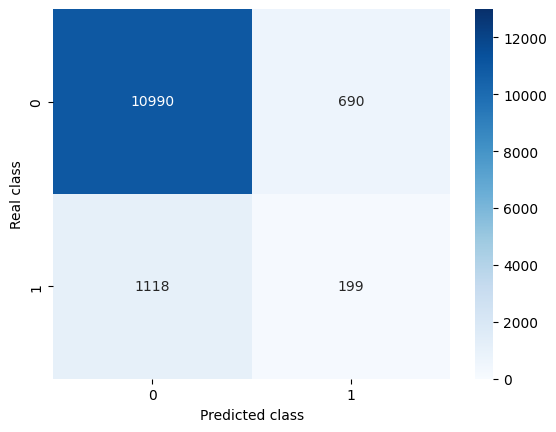

{'Accuracy': 0.8608909748403478,
 'Precision': 0.22384701912260968,
 'Recall': 0.15110098709187547,
 'F1': 0.18041704442429737}

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, random_state=RS, train_size=0.8
)

clf = LogisticRegression(max_iter=300, class_weight=class_weight)

clf.fit(X_train, Y_train)

pred = clf.predict(X_test)

metrics(pred, Y_test)

### 3. Результат после удаления коррелирующих параметров

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     12506
           1       0.12      0.33      0.18       491

    accuracy                           0.89     12997
   macro avg       0.55      0.62      0.56     12997
weighted avg       0.94      0.89      0.91     12997



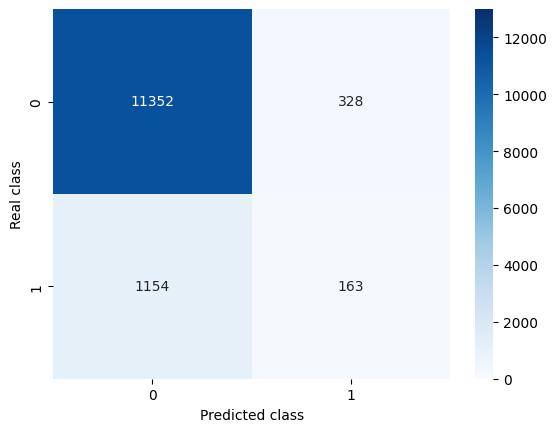

{'Accuracy': 0.885973686235285,
 'Precision': 0.3319755600814664,
 'Recall': 0.12376613515565679,
 'F1': 0.18030973451327434}

In [47]:
features_copy = pd.DataFrame(features_scaled.copy())

for candidate in candidates[:-1]:
  features_copy.drop(candidate, inplace=True, axis=1)
  
X_train, X_test, Y_train, Y_test = train_test_split(features_copy, labels, random_state=RS, train_size=0.8)

cnt_1 = Y_train[Y_train == 1].size
cnt_0 = Y_train[Y_train == 0].size
weight_for_1 = cnt_0 / cnt_1

class_weight = {0: 1, 1: 4}

clf = LogisticRegression(max_iter=300, class_weight=class_weight)

clf.fit(X_train, Y_train)

pred = clf.predict(X_test)

metrics(pred, Y_test)

### 4. Оценка влияния веса малочисленного класса на точность модели.

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     12506
           1       0.12      0.33      0.18       491

    accuracy                           0.89     12997
   macro avg       0.55      0.62      0.56     12997
weighted avg       0.94      0.89      0.91     12997



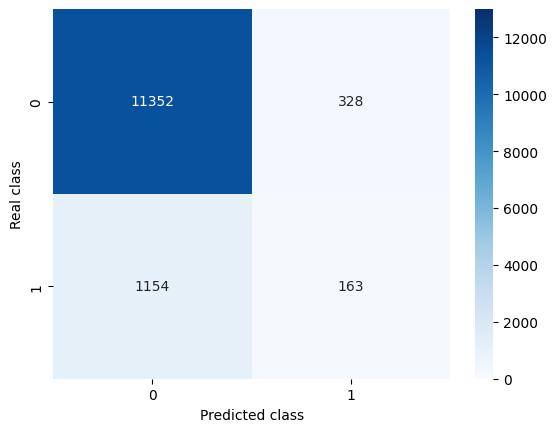

              precision    recall  f1-score   support

           0       0.90      0.91      0.90     11500
           1       0.21      0.18      0.20      1497

    accuracy                           0.83     12997
   macro avg       0.55      0.55      0.55     12997
weighted avg       0.82      0.83      0.82     12997



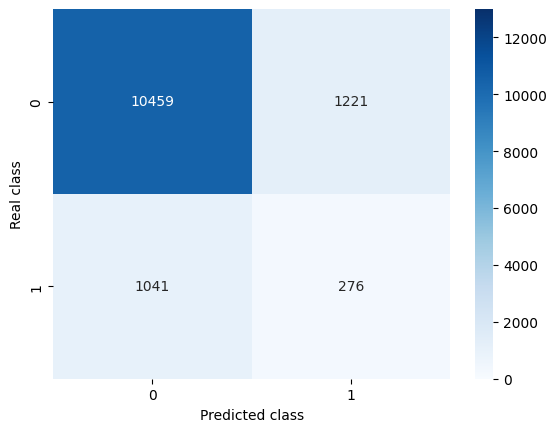

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      9716
           1       0.39      0.16      0.22      3281

    accuracy                           0.72     12997
   macro avg       0.57      0.54      0.53     12997
weighted avg       0.67      0.72      0.68     12997



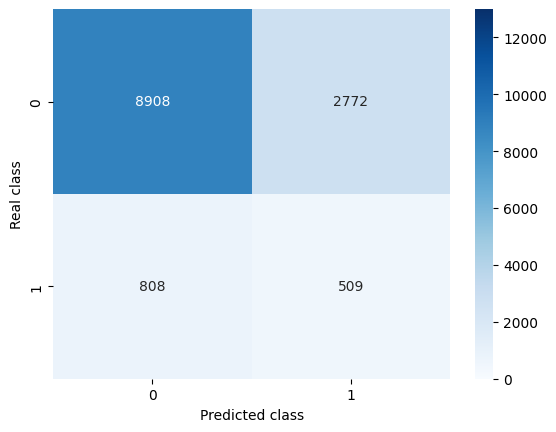

              precision    recall  f1-score   support

           0       0.58      0.93      0.71      7300
           1       0.59      0.14      0.22      5697

    accuracy                           0.58     12997
   macro avg       0.58      0.53      0.47     12997
weighted avg       0.58      0.58      0.50     12997



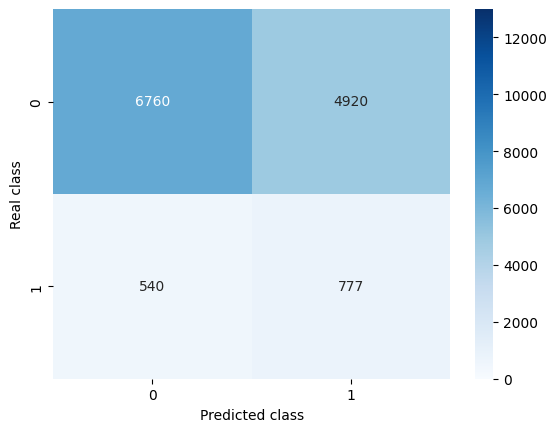

              precision    recall  f1-score   support

           0       0.38      0.94      0.54      4684
           1       0.77      0.12      0.21      8313

    accuracy                           0.42     12997
   macro avg       0.57      0.53      0.37     12997
weighted avg       0.63      0.42      0.33     12997



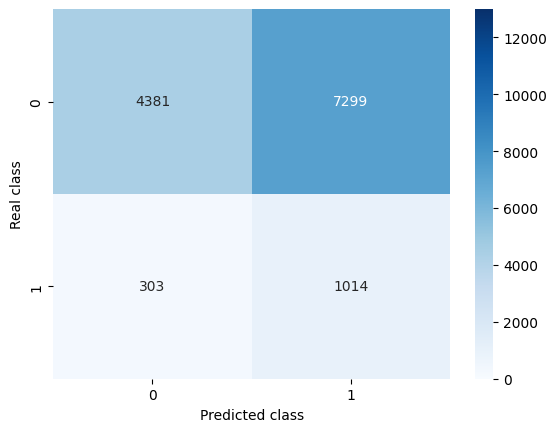

In [48]:
draw_data = []
for w in [4, 6, 8, 10, 12]:
  class_weight = {0: 1, 1: w}

  clf = LogisticRegression(max_iter=300, class_weight=class_weight)

  clf.fit(X_train, Y_train)

  pred = clf.predict(X_test)

  draw_data.append(metrics(pred, Y_test))
  draw_data[-1]["weight"] = w

Best weight for F1 score: 10. 
Best F1 score: 0.2215568862275449


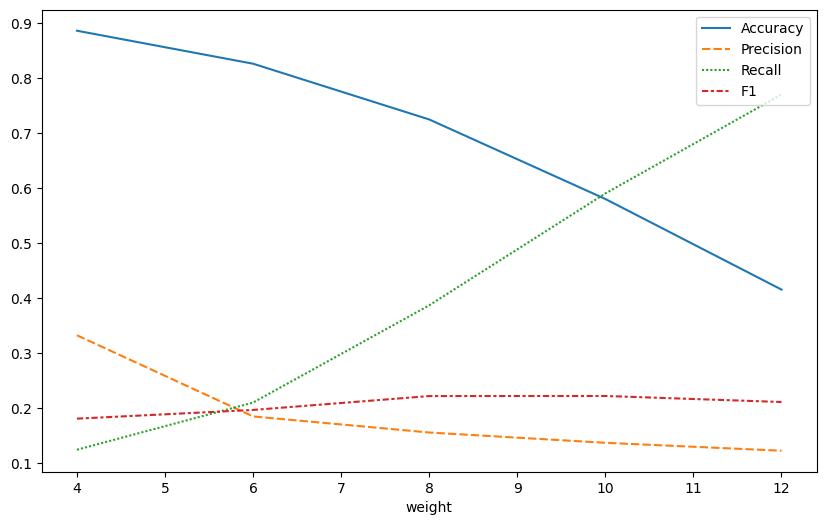

In [49]:
draw_df = pd.DataFrame(draw_data)
param_name = "weight"
draw_df = draw_df.set_index([param_name])

best_weight_f1 = draw_df["F1"].idxmax()
best_f1 = draw_df["F1"].max()

print(f"Best {param_name} for F1 score: {best_weight_f1}. \nBest F1 score: {best_f1}")

plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=draw_df)

plt.legend(loc="upper right")